In [2]:
import os
import numpy as np

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [2]:
# Class to load the dataset
class ImageWoof(ImageFolder):
    """
    Dataset class for ImageWoof dataset.
    """

    DATASET_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"

    def __init__(
        self,
        root: str,
        img_size: int,
        transform=None,
        target_transform=None,
        loader=default_loader,
        is_valid_file=None,
        train=True,
    ):
        if os.path.exists(os.path.join(root, "imagewoof2-160")):
            root = os.path.join(root, "imagewoof2-160")
        elif os.path.exists(os.path.join(root, "imagewoof2-160.tgz")):
            os.system(f"tar zxvf {os.path.join(root, 'imagewoof2-160.tgz')}")
            root = os.path.join(root, "imagewoof2-160")
        else:
            download_url(self.DATASET_URL, ".")
            os.system(f"tar zxvf {os.path.join(root, 'imagewoof2-160.tgz')}")
            root = os.path.join(root, "imagewoof2-160")

        if train:
            root = os.path.join(root, "train")
        else:
            root = os.path.join(root, "val")

        if transform is None:
            transform = transforms.Compose(
                [
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                ]
            )

        super().__init__(root, transform, target_transform, loader, is_valid_file)


In [3]:
#train and test data directory
train_data_dir = "./Dataset/train/"
val_data_dir = "./Dataset/val"

# load the train and val data without Normalization
# Apply default transformation be resizing it to 160 x 160
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))
val_dataset = ImageFolder(val_data_dir,transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))

In [688]:
img, label = train_dataset[2000]
print(img.shape,label)

torch.Size([3, 160, 160]) 2


In [689]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']


Label : n02088364


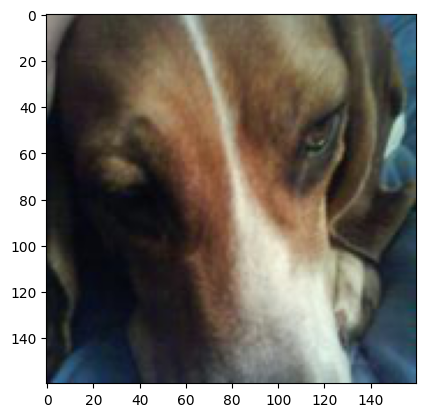

In [690]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[2555])

In [4]:
batch_size = 64

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, num_workers = 4, pin_memory = True)

In [1]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

NameError: name 'train_dl' is not defined

# Baseline Provided Model

In [36]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 7, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(8, 16, 5, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss

        # Calculate training accuracy
        _, predicted = torch.max(out, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_accuracy'] ,  result['val_loss'], result['val_acc']))

# Our Customized Model

In [493]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
            nn.BatchNorm2d(16),
            nn.Dropout(0.35),
            nn.Conv2d(16, 32, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
            nn.BatchNorm2d(32),
            nn.Dropout(0.35),
#             nn.Dropout(0.3),
            #####
#             nn.Conv2d(8, 16, 5, 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 16, 5, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
            #####
#             nn.Conv2d(16, 32, 3, 1),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1),
#             nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.35),
#             nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss

        # Calculate training accuracy
        _, predicted = torch.max(out, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_accuracy'] ,  result['val_loss'], result['val_acc']))

In [494]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping(tolerance=5, min_delta=0.010)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
#     scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.33, total_iters=20)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    best_val_accuracy = 0.0  # Initialize with the lowest possible accuracy
    best_model_weights = model.state_dict()  # Initialize with the current model weights

    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accuracies = []  # List to store training accuracies
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            result = model.training_step(batch)
            loss = result['loss']
            accuracy = result['accuracy']
            
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            
            loss.backward()
            optimizer.step()

        train_loss = torch.stack(train_losses).mean().item()
        train_accuracy = torch.tensor(train_accuracies).mean().item()
        
#         print("Accuracy: " , train_accuracy)
        
        with torch.no_grad():
            result = evaluate(model, val_loader)
            
        val_accuracy = result['val_acc']  # Assuming you're returning accuracy in your validation function
#         print("Validation Accuracy: " , val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict()
            
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, Learning Rate: {current_lr}")
#         print("Hi , " , result)
        result['train_loss'] = train_loss
        result['train_accuracy'] = train_accuracy  # Store training accuracy
        model.epoch_end(epoch, result)
        history.append(result)
        
#         early_stopping(train_loss, result['val_loss'])
#         if early_stopping.early_stop:
#             print("We are at epoch:", epoch , "Hence, Early Stopping Applied.")
#             break
    # Save the best model weights to a file
    torch.save(best_model_weights, 'best_model_weights.pth')
    
    return history

In [495]:
model = CNN()

model.num_of_params()

2704074

In [496]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [497]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [498]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [499]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [500]:
to_device(model, device)
summary(model, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 156, 156]           1,216
              ReLU-2         [-1, 16, 156, 156]               0
         MaxPool2d-3           [-1, 16, 52, 52]               0
       BatchNorm2d-4           [-1, 16, 52, 52]              32
           Dropout-5           [-1, 16, 52, 52]               0
            Conv2d-6           [-1, 32, 48, 48]          12,832
              ReLU-7           [-1, 32, 48, 48]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
       BatchNorm2d-9           [-1, 32, 16, 16]              64
          Dropout-10           [-1, 32, 16, 16]               0
AdaptiveAvgPool2d-11             [-1, 32, 8, 8]               0
           Linear-12                 [-1, 1024]       2,098,176
             ReLU-13                 [-1, 1024]               0
          Dropout-14                 [-

In [501]:
num_epochs = 30
opt_func = torch.optim.SGD
lr = 0.01 #fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.94it/s]


Epoch 1, Learning Rate: 0.01
Epoch [0], train_loss: 2.2324, train_acc: 0.1634, val_loss: 3.2984, val_acc: 0.1038


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 26.90it/s]


Epoch 2, Learning Rate: 0.01
Epoch [1], train_loss: 2.0492, train_acc: 0.2325, val_loss: 2.0247, val_acc: 0.2597


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.63it/s]


Epoch 3, Learning Rate: 0.01
Epoch [2], train_loss: 1.9647, train_acc: 0.2640, val_loss: 1.9292, val_acc: 0.3021


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.19it/s]


Epoch 4, Learning Rate: 0.01
Epoch [3], train_loss: 1.9095, train_acc: 0.3050, val_loss: 1.9354, val_acc: 0.3002


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.55it/s]


Epoch 5, Learning Rate: 0.001
Epoch [4], train_loss: 1.8357, train_acc: 0.3338, val_loss: 1.8156, val_acc: 0.3494


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.23it/s]


Epoch 6, Learning Rate: 0.001
Epoch [5], train_loss: 1.7256, train_acc: 0.3818, val_loss: 1.7746, val_acc: 0.3668


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.67it/s]


Epoch 7, Learning Rate: 0.001
Epoch [6], train_loss: 1.7040, train_acc: 0.3796, val_loss: 1.8005, val_acc: 0.3632


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 29.07it/s]


Epoch 8, Learning Rate: 0.001
Epoch [7], train_loss: 1.6894, train_acc: 0.3976, val_loss: 1.7876, val_acc: 0.3605


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.23it/s]


Epoch 9, Learning Rate: 0.001
Epoch [8], train_loss: 1.6881, train_acc: 0.3938, val_loss: 1.8002, val_acc: 0.3619


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.17it/s]


Epoch 10, Learning Rate: 0.0001
Epoch [9], train_loss: 1.6525, train_acc: 0.4026, val_loss: 1.7393, val_acc: 0.3848


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.17it/s]


Epoch 11, Learning Rate: 0.0001
Epoch [10], train_loss: 1.6461, train_acc: 0.4152, val_loss: 1.7494, val_acc: 0.3806


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.42it/s]


Epoch 12, Learning Rate: 0.0001
Epoch [11], train_loss: 1.6343, train_acc: 0.4099, val_loss: 1.7354, val_acc: 0.3814


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 29.15it/s]


Epoch 13, Learning Rate: 0.0001
Epoch [12], train_loss: 1.6254, train_acc: 0.4233, val_loss: 1.7370, val_acc: 0.3867


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 29.10it/s]


Epoch 14, Learning Rate: 0.0001
Epoch [13], train_loss: 1.6228, train_acc: 0.4160, val_loss: 1.7372, val_acc: 0.3856


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.76it/s]


Epoch 15, Learning Rate: 1e-05
Epoch [14], train_loss: 1.6151, train_acc: 0.4153, val_loss: 1.7476, val_acc: 0.3856


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.18it/s]


Epoch 16, Learning Rate: 1e-05
Epoch [15], train_loss: 1.6199, train_acc: 0.4144, val_loss: 1.7534, val_acc: 0.3823


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.89it/s]


Epoch 17, Learning Rate: 1e-05
Epoch [16], train_loss: 1.6119, train_acc: 0.4123, val_loss: 1.7391, val_acc: 0.3865


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.99it/s]


Epoch 18, Learning Rate: 1e-05
Epoch [17], train_loss: 1.6357, train_acc: 0.4137, val_loss: 1.7382, val_acc: 0.3856


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.89it/s]


Epoch 19, Learning Rate: 1e-05
Epoch [18], train_loss: 1.6158, train_acc: 0.4272, val_loss: 1.7684, val_acc: 0.3805


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.50it/s]


Epoch 20, Learning Rate: 1.0000000000000002e-06
Epoch [19], train_loss: 1.6128, train_acc: 0.4209, val_loss: 1.7529, val_acc: 0.3868


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.71it/s]


Epoch 21, Learning Rate: 1.0000000000000002e-06
Epoch [20], train_loss: 1.6185, train_acc: 0.4152, val_loss: 1.7513, val_acc: 0.3811


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.63it/s]


Epoch 22, Learning Rate: 1.0000000000000002e-06
Epoch [21], train_loss: 1.6141, train_acc: 0.4226, val_loss: 1.7664, val_acc: 0.3794


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.11it/s]


Epoch 23, Learning Rate: 1.0000000000000002e-06
Epoch [22], train_loss: 1.6210, train_acc: 0.4155, val_loss: 1.7436, val_acc: 0.3871


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.93it/s]


Epoch 24, Learning Rate: 1.0000000000000002e-06
Epoch [23], train_loss: 1.6326, train_acc: 0.4160, val_loss: 1.7346, val_acc: 0.3817


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.84it/s]


Epoch 25, Learning Rate: 1.0000000000000002e-07
Epoch [24], train_loss: 1.6205, train_acc: 0.4220, val_loss: 1.7664, val_acc: 0.3792


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.45it/s]


Epoch 26, Learning Rate: 1.0000000000000002e-07
Epoch [25], train_loss: 1.6156, train_acc: 0.4218, val_loss: 1.7530, val_acc: 0.3826


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.45it/s]


Epoch 27, Learning Rate: 1.0000000000000002e-07
Epoch [26], train_loss: 1.6096, train_acc: 0.4246, val_loss: 1.7453, val_acc: 0.3841


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 28.38it/s]


Epoch 28, Learning Rate: 1.0000000000000002e-07
Epoch [27], train_loss: 1.6125, train_acc: 0.4203, val_loss: 1.7451, val_acc: 0.3848


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.70it/s]


Epoch 29, Learning Rate: 1.0000000000000002e-07
Epoch [28], train_loss: 1.6250, train_acc: 0.4142, val_loss: 1.7766, val_acc: 0.3726


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.63it/s]


Epoch 30, Learning Rate: 1.0000000000000004e-08
Epoch [29], train_loss: 1.6088, train_acc: 0.4228, val_loss: 1.7515, val_acc: 0.3856


## Our Own Model Graphs

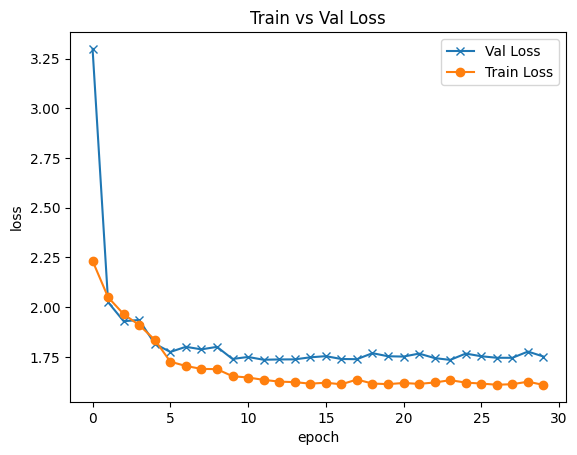

In [502]:
# Plot Validation vs Training Loss

losses_val = [x['val_loss'] for x in history]
losses_train = [x['train_loss'] for x in history]
plt.plot(losses_val, '-x', label ='Val Loss' )
plt.plot(losses_train, '-o', label ='Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train vs Val Loss')
plt.legend()

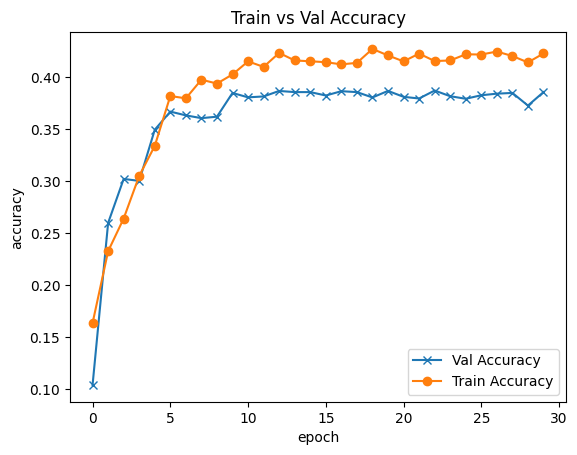

In [503]:
val_accuracies = [x['val_acc'] for x in history]
train_accuracies = [x['train_accuracy'] for x in history]
plt.plot(val_accuracies, '-x' , label ='Val Accuracy')
plt.plot(train_accuracies, '-o', label ='Train Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()

In [504]:
# Save the history for plotting
import pickle
with open('./Task 1.4/Drop/Model 1.4.6_Dr', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [505]:
# Print all the files for that specific task. The files are 
# actually history of the model training which will then be 
# used to plot the graphs

total_files = os.listdir('./Task 1.4/Drop/')
total_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
total_files

['Model 1.4.4_Dr', 'Model 1.4.5_Dr', 'Model 1.4.6_Dr']

In [506]:
# Load all the history files from data folder to plot them collectively

history_all = []
for i in range(len(total_files)):
    with open(f'./Task 1.4/Drop/{total_files[i]}', "rb") as file_pi:
        history_new = pickle.load(file_pi)
        history_all.append(history_new)
    
history_all

[[{'val_loss': 2.289508104324341,
   'val_acc': 0.1547379046678543,
   'train_loss': 2.1824791431427,
   'train_accuracy': 0.17671655118465424},
  {'val_loss': 2.375206470489502,
   'val_acc': 0.17597782611846924,
   'train_loss': 1.9849350452423096,
   'train_accuracy': 0.2684859037399292},
  {'val_loss': 2.3428378105163574,
   'val_acc': 0.20388105511665344,
   'train_loss': 1.9001818895339966,
   'train_accuracy': 0.31800174713134766},
  {'val_loss': 1.9307371377944946,
   'val_acc': 0.29069554805755615,
   'train_loss': 1.8386878967285156,
   'train_accuracy': 0.3356073796749115},
  {'val_loss': 1.792333722114563,
   'val_acc': 0.35272178053855896,
   'train_loss': 1.7334824800491333,
   'train_accuracy': 0.37522006034851074},
  {'val_loss': 1.6807758808135986,
   'val_acc': 0.4138306677341461,
   'train_loss': 1.5484017133712769,
   'train_accuracy': 0.4513644278049469},
  {'val_loss': 1.6797432899475098,
   'val_acc': 0.4167137145996094,
   'train_loss': 1.5014511346817017,
   't

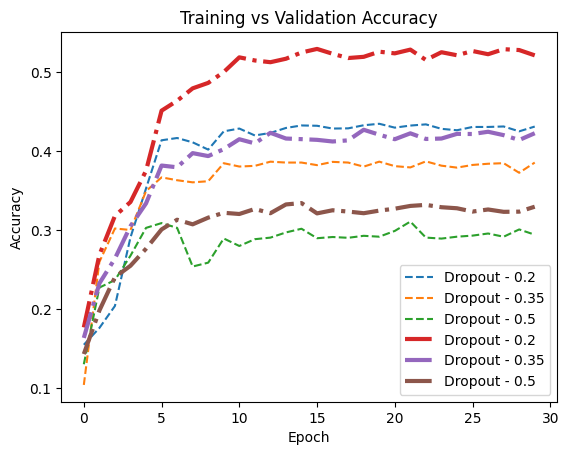

In [507]:
# Plot graphs for validation accuracy

plt.plot([x['val_acc'] for x in history_all[0]], linestyle='dashed' , label ='Dropout - 0.2')
plt.plot([x['val_acc'] for x in history_all[2]], linestyle='dashed' , label ='Dropout - 0.35')
plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='Dropout - 0.5')


plt.plot([x['train_accuracy'] for x in history_all[0]], linestyle='-.' , linewidth=3, label ='Dropout - 0.2')
plt.plot([x['train_accuracy'] for x in history_all[2]], linestyle='-.' , linewidth=3, label ='Dropout - 0.35')
plt.plot([x['train_accuracy'] for x in history_all[1]], linestyle='-.' , linewidth=3, label ='Dropout - 0.5')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


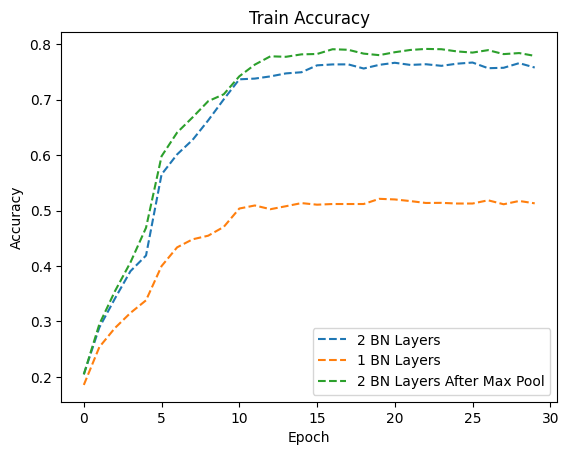

In [381]:
plt.plot([x['train_accuracy'] for x in history_all[0]], linestyle='dashed' , label ='2 BN Layers')
plt.plot([x['train_accuracy'] for x in history_all[1]], linestyle='dashed' , label ='1 BN Layers')
plt.plot([x['train_accuracy'] for x in history_all[2]], linestyle='dashed' , label ='2 BN Layers After Max Pool')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.legend()


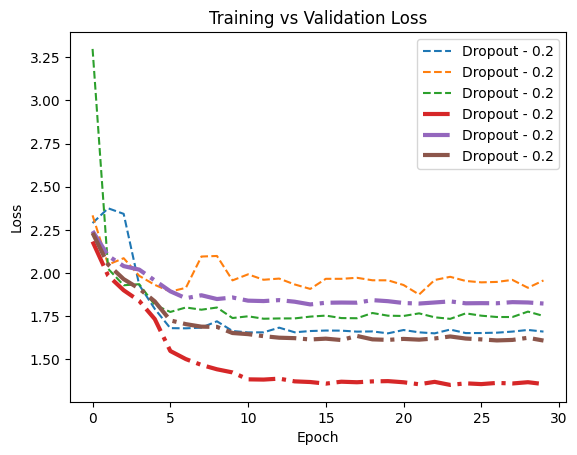

In [508]:
plt.plot([x['val_loss'] for x in history_all[0]], linestyle='dashed' , label ='Dropout - 0.2')
plt.plot([x['val_loss'] for x in history_all[1]], linestyle='dashed' , label ='Dropout - 0.2')
plt.plot([x['val_loss'] for x in history_all[2]], linestyle='dashed' , label ='Dropout - 0.2')


plt.plot([x['train_loss'] for x in history_all[0]], linestyle='-.' , linewidth=3, label ='Dropout - 0.2')
plt.plot([x['train_loss'] for x in history_all[1]], linestyle='-.' , linewidth=3, label ='Dropout - 0.2')
plt.plot([x['train_loss'] for x in history_all[2]], linestyle='-.' , linewidth=3, label ='Dropout - 0.2')



# plt.plot(history_all, '-o', label ='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

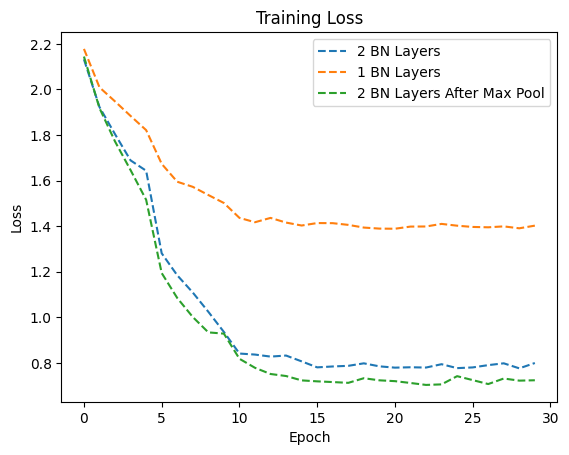

In [384]:
plt.plot([x['train_loss'] for x in history_all[0]], linestyle='dashed' , label ='2 BN Layers')
plt.plot([x['train_loss'] for x in history_all[1]], linestyle='dashed' , label ='1 BN Layers')
plt.plot([x['train_loss'] for x in history_all[2]], linestyle='dashed' , label ='2 BN Layers After Max Pool')


# plt.plot(history_all, '-o', label ='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()